In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
'''
TO GET THE DATA
https://www.kaggle.com/yashvrdnjain/hotdognothotdog
Please visit the link (login) to kaggle, and download the zip
'''

In [29]:
import pathlib
data_dir = '../datasets/hotdog-nothotdog/train/'
data_dir = pathlib.Path(data_dir)

In [21]:
train_image_count = len(list(data_dir.glob('train/*/*.jpg')))
test_image_count = len(list(data_dir.glob('test/*/*.jpg')))
train_hotdogs = len(list(data_dir.glob('train/hotdog/*.jpg')))
train_nothotdogs = len(list(data_dir.glob('train/nothotdog/*.jpg')))

print("Number of train and test images:",train_image_count,test_image_count)
print("Number of HotDog and NotHotDog images:",train_hotdogs,train_nothotdogs)

Number of train and test images: 3000 644
Number of HotDog and NotHotDog images: 1500 1500


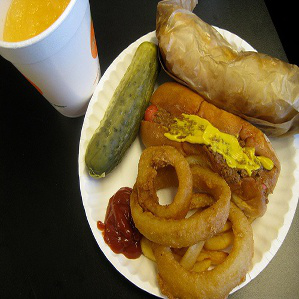

In [24]:
#display images
hotdogs = list(data_dir.glob('train/hotdog/*'))
nothotdogs = list(data_dir.glob('train/nothotdog/*'))
PIL.Image.open(str(hotdogs[2]))

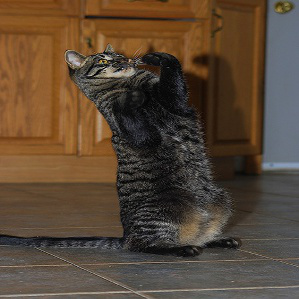

In [26]:
PIL.Image.open(str(nothotdogs[1]))

In [38]:
#setting up the training dataset
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# validation split
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.
['hotdog', 'nothotdog']


In [31]:
class_names = train_ds.class_names
print(class_names)

['hotdog', 'nothotdog']


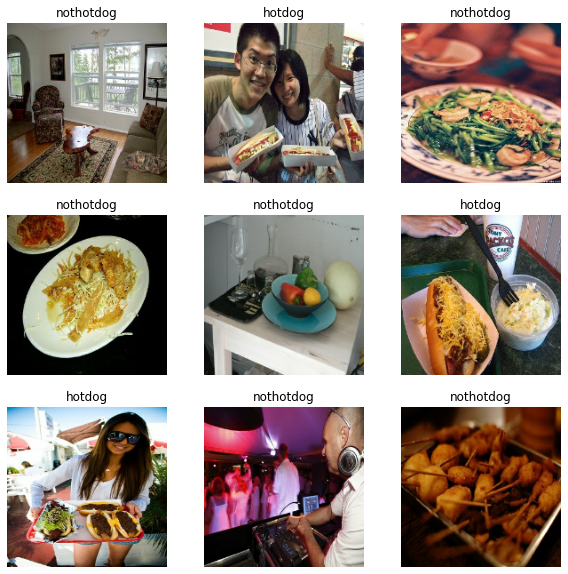

In [33]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [34]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [35]:
'''
Standardizing the data
'''
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [36]:
# There are two ways to use this layer. You can apply it to the dataset by calling map
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [39]:
#Configure the dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

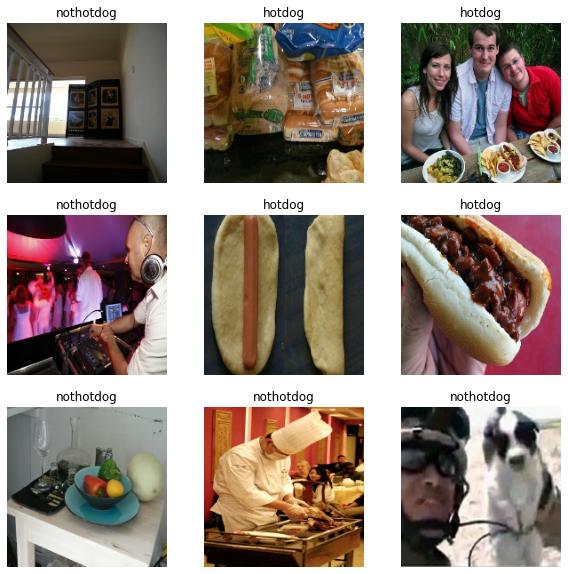

In [40]:
'''
Visualizing the data 
'''
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [41]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [43]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [44]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [46]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
75/75 [==============================] - 19s 219ms/step - loss: 0.8513 - accuracy: 0.5445 - val_loss: 0.5888 - val_accuracy: 0.6817
Epoch 2/10
75/75 [==============================] - 16s 206ms/step - loss: 0.6109 - accuracy: 0.6753 - val_loss: 0.5978 - val_accuracy: 0.6867
Epoch 3/10
75/75 [==============================] - 14s 188ms/step - loss: 0.5317 - accuracy: 0.7477 - val_loss: 0.5392 - val_accuracy: 0.7467
Epoch 4/10
75/75 [==============================] - 15s 195ms/step - loss: 0.4788 - accuracy: 0.7739 - val_loss: 0.5667 - val_accuracy: 0.7150
Epoch 5/10
75/75 [==============================] - 14s 186ms/step - loss: 0.3968 - accuracy: 0.8286 - val_loss: 0.6536 - val_accuracy: 0.6833
Epoch 6/10
75/75 [==============================] - 14s 186ms/step - loss: 0.3521 - accuracy: 0.8438 - val_loss: 0.6023 - val_accuracy: 0.7083
Epoch 7/10
75/75 [==============================] - 14s 193ms/step - loss: 0.2491 - accuracy: 0.9055 - val_loss: 0.7820 - val_accuracy: 0.7350

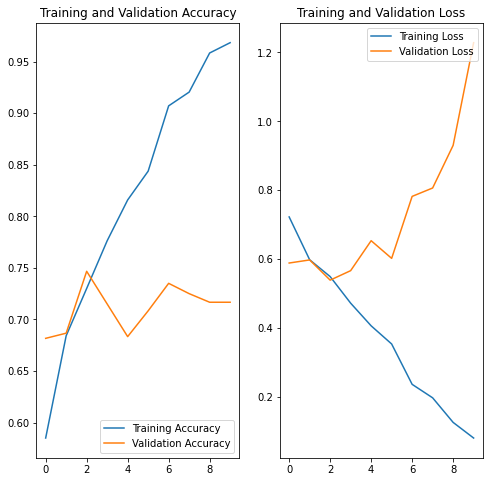

In [47]:
#visualiza training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
#data augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [50]:
#using dropouts
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [51]:
#redefining training hparams, retraining new model
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
75/75 [==============================] - 16s 209ms/step - loss: 0.8317 - accuracy: 0.5319 - val_loss: 0.5941 - val_accuracy: 0.6750
Epoch 2/15
75/75 [==============================] - 16s 214ms/step - loss: 0.6174 - accuracy: 0.6660 - val_loss: 0.5853 - val_accuracy: 0.6950
Epoch 3/15
75/75 [==============================] - 16s 213ms/step - loss: 0.5887 - accuracy: 0.6937 - val_loss: 0.5702 - val_accuracy: 0.7033
Epoch 4/15
75/75 [==============================] - 16s 210ms/step - loss: 0.5519 - accuracy: 0.7335 - val_loss: 0.5897 - val_accuracy: 0.7000
Epoch 5/15
75/75 [==============================] - 16s 211ms/step - loss: 0.5795 - accuracy: 0.7057 - val_loss: 0.6513 - val_accuracy: 0.6667
Epoch 6/15
75/75 [==============================] - 16s 209ms/step - loss: 0.5448 - accuracy: 0.7137 - val_loss: 0.6420 - val_accuracy: 0.6650
Epoch 7/15
75/75 [==============================] - 16s 215ms/step - loss: 0.5239 - accuracy: 0.7327 - val_loss: 0.5209 - val_accuracy: 0.7250

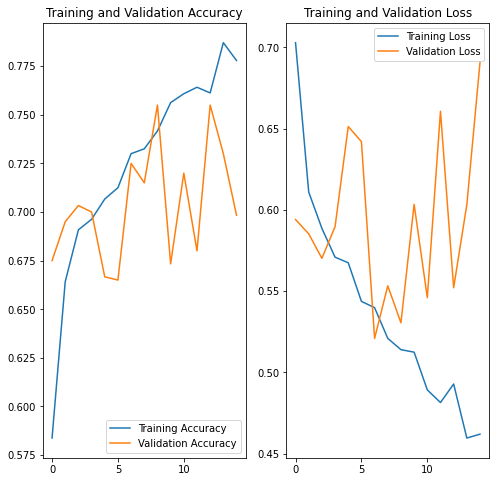

In [52]:
# We see that dropout regularization did not work in this case. We'll keep the first model, 0.71 versus 0.69. 
# We will try all regularization methods, to make the results better.

#visualizing new training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()